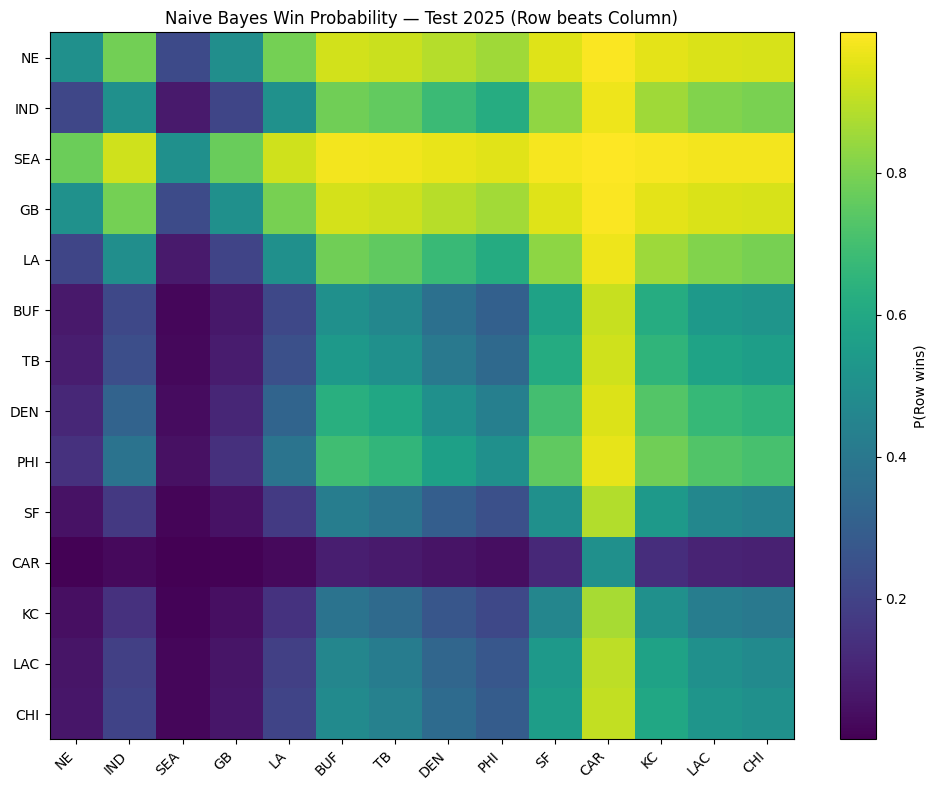

Training rows: 416 | Pairwise samples: 12896
Test season: 2025 | Teams evaluated: 14
Common feature count: 63


In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
TRAIN_PATH = "team_stats_with_fantasy_clean.csv"   # yearly (train)
TEST_PATH  = "merged_file.csv"             # nfl (test)
ID_COLS = ["team", "season", "season_type"]
TARGET = "win_pct"

# ----------------------------
# Utilities
# ----------------------------
def ensure_win_pct(df, base_name=""):
    """
    Ensure df has a 'win_pct' column.
    Accepts: 'win_pct', 'win_pct_off', 'win_pct_def';
    else computes from (win, loss, tie) or suffixed variants.
    """
    # 1) Direct presence
    for cand in [TARGET, f"{TARGET}_off", f"{TARGET}_def"]:
        if cand in df.columns:
            if cand != TARGET:
                df[TARGET] = df[cand]
            return df

    # 2) Compute from wins/losses/ties
    def pick(col):
        for c in [col, f"{col}_off", f"{col}_def"]:
            if c in df.columns:
                return c
        return None

    win_c  = pick("win")
    loss_c = pick("loss")
    tie_c  = pick("tie")

    if win_c and loss_c:
        wins  = pd.to_numeric(df[win_c], errors="coerce").fillna(0)
        losses = pd.to_numeric(df[loss_c], errors="coerce").fillna(0)
        ties   = pd.to_numeric(df[tie_c], errors="coerce").fillna(0) if tie_c else 0
        denom = wins + losses + ties
        df[TARGET] = np.where(denom != 0, (wins + 0.5 * ties) / denom, 0.0)
        return df

    # 3) Fallback: if nothing found, create 0.0 (avoid crash; model won’t be meaningful)
    df[TARGET] = 0.0
    return df

def common_numeric_features(train_df, test_df, exclude):
    tn = train_df.select_dtypes(include=[np.number]).columns.tolist()
    ts = test_df.select_dtypes(include=[np.number]).columns.tolist()
    train_feats = [c for c in tn if c not in exclude]
    test_feats  = [c for c in ts if c not in exclude]
    return sorted(list(set(train_feats) & set(test_feats)))

# ----------------------------
# Load
# ----------------------------
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Keep regular season only (if present)
if "season_type" in train_df.columns:
    train_df = train_df[train_df["season_type"] != "POST"].copy()
if "season_type" in test_df.columns:
    test_df = test_df[test_df["season_type"] != "POST"].copy()

# Ensure required ID columns exist
for c in ID_COLS:
    if c not in train_df.columns: train_df[c] = np.nan
    if c not in test_df.columns:  test_df[c]  = np.nan

# Ensure TARGET exists (discover or compute)
train_df = ensure_win_pct(train_df)
test_df  = ensure_win_pct(test_df)

# ----------------------------
# Feature selection & alignment
# ----------------------------
EXCLUDE = set(ID_COLS + [TARGET, "win", "loss", "tie", "record",
                          "win_off","loss_off","tie_off","record_off",
                          "win_def","loss_def","tie_def","record_def",
                          "win_pct_off","win_pct_def"])  # avoid leakage

common_feats = common_numeric_features(train_df, test_df, EXCLUDE)
if not common_feats:
    raise ValueError("No common numeric feature columns between train and test after exclusions.")

# ----------------------------
# Build pairwise training data (yearly file)
# ----------------------------
pairs_X, pairs_y = [], []
for season, G in train_df.groupby("season"):
    G = G.reset_index(drop=True)
    Xs = G[common_feats].fillna(0).to_numpy()
    ys = G[TARGET].astype(float).to_numpy()
    for i, j in combinations(range(len(G)), 2):
        d = Xs[i] - Xs[j]
        y = 1 if ys[i] > ys[j] else 0
        pairs_X.append(d); pairs_y.append(y)
        pairs_X.append(-d); pairs_y.append(1 - y)

pairs_X = np.asarray(pairs_X)
pairs_y = np.asarray(pairs_y)

# ----------------------------
# Train
# ----------------------------
clf = make_pipeline(StandardScaler(with_mean=True, with_std=True), GaussianNB())
clf.fit(pairs_X, pairs_y)

# ----------------------------
# Evaluate on TEST file (latest season top-14 by TARGET)
# ----------------------------
latest_test_season = int(test_df["season"].max())
cur = test_df[test_df["season"] == latest_test_season].copy()

# If target has NaNs, fill benignly
cur[TARGET] = pd.to_numeric(cur[TARGET], errors="coerce").fillna(cur[TARGET].median() if cur[TARGET].notna().any() else 0.0)

cur = cur.set_index("team")
top14 = cur[TARGET].sort_values(ascending=False).head(14).index.tolist()
X_cur = cur.loc[top14, common_feats].fillna(0).to_numpy()

# Win-probability matrix
n = len(top14)
prob = np.zeros((n, n))
for a in range(n):
    for b in range(n):
        if a == b:
            prob[a, b] = 0.5
        else:
            diff = (X_cur[a] - X_cur[b]).reshape(1, -1)
            prob[a, b] = clf.predict_proba(diff)[0, 1]
            

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(prob, aspect='auto')
ax.set_xticks(range(n)); ax.set_yticks(range(n))
ax.set_xticklabels(top14, rotation=45, ha='right')
ax.set_yticklabels(top14)
ax.set_title(f"Naive Bayes Win Probability — Test {latest_test_season} (Row beats Column)")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("P(Row wins)")
plt.tight_layout()
plt.show()

print(f"Training rows: {len(train_df)} | Pairwise samples: {len(pairs_y)}")
print(f"Test season: {latest_test_season} | Teams evaluated: {len(top14)}")
print(f"Common feature count: {len(common_feats)}")
